**Dirichlet Variational Autoencoder (DVAE)**
---
**Imports**

---

External libraries required for operation

In [1]:
import json
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from data_preprocessor import data_preprocessor as preproc
from data_splitter import fixed_splitter as fs
from model_manager import model_generator, model_trainer, model_storage
from grapher import graph_generator as gg
from tensorflow.keras import Model
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam



2025-07-25 11:19:42.307808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-25 11:19:42.316044: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-25 11:19:42.332331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753467582.358344 2579422 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753467582.366016 2579422 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753467582.388764 2579422 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Opening the trainer_config.json file:

In [2]:
TRAINER_CONFIG_FILE_LOCATION = 'config/trainer_config.json'
with open(TRAINER_CONFIG_FILE_LOCATION, 'r') as file:
    train_config = json.load(file)

**Data Preprocessing**

---

This block will open and validate the background data file. It must contain the directory "Particles" within it in order for us to continue. It will then save it into a numpy array to be used for model training.

In [3]:
preprocessed_data = preproc.get_data(train_config)

Ato4l = preproc.get_data(train_config, "Ato4l_lepFilter_13TeV")
hToTauTau = preproc.get_data(train_config, "hToTauTau_13TeV_PU20")
hChToTauNu = preproc.get_data(train_config, "hChToTauNu_13TeV_PU20")
leptoquark = preproc.get_data(train_config, "leptoquark_LOWMASS_lepFilter_13TeV")

Ato4l = preproc.normalize_data(Ato4l)
hToTauTau = preproc.normalize_data(hToTauTau)
hChToTauNu = preproc.normalize_data(hChToTauNu)
leptoquark = preproc.normalize_data(leptoquark)

signal_data = np.concatenate([
    Ato4l, 
    hToTauTau,
    hChToTauNu,
    leptoquark
])

data_train, data_validate, data_test = fs.generate_fixed_trainingdata_split(train_config, preprocessed_data, True)

Generated The Following Datasets
 Train Data Shape : (2000000, 57)
 Validation Data Shape : (399999, 57)
 Test Data Shape : (70000, 57)


**Model Initialization**

---

Initialize an instance of the above class

In [4]:
class EDLModel(Model): # TODO make this into its own function, having the priot_alpha is undefined bug, not sure why
    """
    This model replaces the VAE parameters with the Dirichlet Paramaters

    """
    def __init__(self, train_config):
        super(EDLModel, self).__init__()
        self.input_shape = (train_config["encoder_design"]["input_layer_dimension"],)
        self.latent_dim = 2 # This is fixed since we have just two classes
        self.train_config = train_config
        self.kl_losses = []

        # Encoder
        self.encoder_input = layers.Input(shape=self.input_shape)
        dimensions = train_config["encoder_design"]["inner_layer_dimensions"]
        x = self.encoder_input
        for dim in dimensions:
            self.encoder_x = layers.Dense(dim, activation='relu')(x)
            x = self.encoder_x
        self.alpha = layers.Dense(self.latent_dim, activation='softplus')(self.encoder_x)
        self.z = Sampling()(self.alpha)

        # Decoder
        self.decoder_input = layers.Input(shape=(self.latent_dim,))
        op_layer_dimension_list = train_config["decoder_design"]["inner_layer_dimensions"]
        x = self.decoder_input
        for dim in op_layer_dimension_list:
            self.decoder_x = layers.Dense(dim, activation='relu')(x)
            x = self.decoder_x
        self.decoder_output = layers.Dense(self.input_shape[0], activation='relu')(self.decoder_x)

        self.encoder = Model(self.encoder_input, [self.z, self.alpha])
        self.decoder = Model(self.decoder_input, self.decoder_output)

        self.num_classes = train_config["encoder_design"]["latent_layer_dimension"]
        self.prior_alpha = tf.constant([1.0] * self.num_classes, dtype=tf.float32)

    def call(self, inputs):
        alpha, z = self.encoder(inputs)
        prior_alpha = tf.broadcast_to(self.prior_alpha, tf.shape(alpha))
        strength = self.train_config["hyperparameters"]["kl_strength"]
        kl_loss = strength * tf.reduce_sum(tfp.distributions.Dirichlet(alpha).kl_divergence(tfp.distributions.Dirichlet(prior_alpha))) #TODO debug 
        reconstructed = self.decoder(z)
        mse = tf.keras.losses.MeanSquaredError()
        reconstruction_loss = mse(inputs, reconstructed) * self.input_shape[0]

        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        return reconstructed


class Sampling(layers.Layer):
    """Uses the alpha dirichlet to sample"""

    def call(self, inputs):
        return tfp.distributions.Dirichlet(inputs).sample()
    
model = EDLModel(train_config)

2025-07-25 11:21:53.558675: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


**Model Training**

---

In [5]:
early_stopping = EarlyStopping(patience=train_config["hyperparameters"]["stop_patience"], restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=train_config["hyperparameters"]["lr_patience"], verbose=1)

print("compiling EDL")
model.compile(optimizer=Adam())
x_train = data_train
y_train = data_train
x_val = data_validate
y_val = data_validate
history = model.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_val, y_val),
            epochs=train_config["hyperparameters"]["epochs"],
            batch_size=train_config["hyperparameters"]["batch_size"],
            callbacks=[early_stopping, reduce_lr]
            )

compiling EDL
Epoch 1/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 3178346.0000 - val_loss: 227.7793 - learning_rate: 0.0010
Epoch 2/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 187.7267 - val_loss: 110.7815 - learning_rate: 0.0010
Epoch 3/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 98.3546 - val_loss: 70.5027 - learning_rate: 0.0010
Epoch 4/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 64.8676 - val_loss: 52.2041 - learning_rate: 0.0010
Epoch 5/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 49.8943 - val_loss: 44.1426 - learning_rate: 0.0010


**Model Evaluation**

---

Processing the signal data

In [6]:
# gg.generate_loss_vs_epoch(train_config, history)

N = 50000
data_test = data_test[:50000]
Ato4l = Ato4l[:50000]
hToTauTau = hToTauTau[:50000]
hChToTauNu = hChToTauNu[:50000]
leptoquark = leptoquark[:50000]

strength = model.train_config["hyperparameters"]["kl_strength"]
num_classes = model.latent_dim
prior_alpha_constant = tf.constant([1.0] * num_classes, dtype=tf.float32)

alpha, z = model.encoder(data_test)
prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
                                tfp.distributions.Dirichlet(prior_alpha_broadcasted))
kl_background = (strength * kl_divergences_per_sample).numpy()

alpha, z = model.encoder(Ato4l)
prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
                                tfp.distributions.Dirichlet(prior_alpha_broadcasted))
kl_Ato4l = (strength * kl_divergences_per_sample).numpy()

alpha, z = model.encoder(hToTauTau)
prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
                                tfp.distributions.Dirichlet(prior_alpha_broadcasted))
kl_hToTauTau = (strength * kl_divergences_per_sample).numpy()

alpha, z = model.encoder(hChToTauNu)
prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
                                tfp.distributions.Dirichlet(prior_alpha_broadcasted))
kl_hChToTauNu = (strength * kl_divergences_per_sample).numpy()

alpha, z = model.encoder(leptoquark)
prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
                                tfp.distributions.Dirichlet(prior_alpha_broadcasted))
kl_leptoquark = (strength * kl_divergences_per_sample).numpy()



reconstructed_background = model(data_test).numpy()
reconstructed_Ato4l = model(Ato4l).numpy()
reconstructed_hToTauTau = model(hToTauTau).numpy()
reconstructed_hChToTauNu = model(hChToTauNu).numpy()
reconstructed_leptoquark = model(leptoquark).numpy()

background_scores = ((reconstructed_background-data_test)**2)
Ato4l_scores = ((reconstructed_Ato4l - Ato4l)**2)
hToTauTau_scores = ((reconstructed_hToTauTau - hToTauTau)**2)
hChToTauNu_scores = ((reconstructed_hChToTauNu - hChToTauNu)**2)
leptoquark_scores = ((reconstructed_leptoquark - leptoquark)**2)

background_scores = np.mean(background_scores,axis=1,keepdims=True)
Ato4l_scores = np.mean(Ato4l_scores,axis=1,keepdims=True)
hToTauTau_scores = np.mean(hToTauTau_scores,axis=1,keepdims=True)
hChToTauNu_scores = np.mean(hChToTauNu_scores,axis=1,keepdims=True)
leptoquark_scores = np.mean(leptoquark_scores,axis=1,keepdims=True)


Generate AUC and loss histograms, seeing if we can get that anomaly score to work...

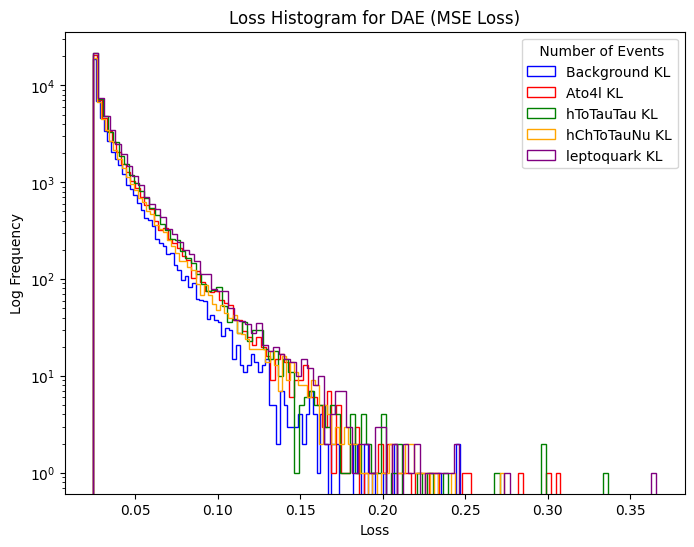

In [22]:
# gg.generate_roc_curve(train_config, truth_values, scores)
plt.figure(figsize=(8, 6))

#MSE loss
# plt.hist(background_scores, histtype='step', bins=train_config["outputs"]["bins"], label='Background MSE', color='blue')
# plt.hist(Ato4l_scores, histtype='step', bins=train_config["outputs"]["bins"], label='Ato4l MSE', color='red')
# plt.hist(hToTauTau_scores, histtype='step', bins=train_config["outputs"]["bins"], label='hToTauTau MSE', color= 'green')
# plt.hist(hChToTauNu_scores, histtype='step', bins=train_config["outputs"]["bins"], label='hChToTauNu MSE', color='orange')
# plt.hist(leptoquark_scores,histtype='step', bins = train_config["outputs"]["bins"], label='leptoquark MSE', color='purple')

#KL Loss
plt.hist(kl_background, histtype='step', bins=train_config["outputs"]["bins"], label='Background KL', color = 'blue')
plt.hist(kl_Ato4l, histtype='step', bins=train_config["outputs"]["bins"],label='Ato4l KL', color = 'red')
plt.hist(kl_hToTauTau, histtype='step', bins=train_config["outputs"]["bins"], label = 'hToTauTau KL', color='green')
plt.hist(kl_hChToTauNu, histtype='step', bins=train_config["outputs"]["bins"], label = 'hChToTauNu KL', color='orange')
plt.hist(kl_leptoquark, histtype='step', bins=train_config["outputs"]["bins"], label = 'leptoquark KL',color='purple')


plt.xlabel('Loss')
plt.ylabel('Log Frequency')
plt.yscale('log')
plt.title("Loss Histogram for DAE (MSE Loss)")
plt.legend(title=" Number of Events")
# plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
        # train_config["outputs"]["date_time_format"]) + "_Histogram.png"), format="png", bbox_inches="tight")
plt.show()


In [8]:
# gg.generate_histogram(train_config, background_scores, signal_scores, train_config["data_files"]["signal_labels"] )